In [1]:
import h5py
import numpy as np
import numpy.ma as ma
import scipy
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from astropy.stats import LombScargle
import datetime
from datetime import date

In [2]:
def defining_variables(ISRdata):
    
    """
    Defines the varibles needed for each h5 file.
    
    Used in the Ne_function and the rel_e_den_array_function.
    """
    
    all_electron_density = np.array(ISRdata['NeFromPower/Ne_NoTr'])
    
    all_altitude = np.array(ISRdata['NeFromPower/Altitude'])
    altitude_slice = np.array(all_altitude[0,:])
    altitude_slice_km = altitude_slice/1000.
    lower_limit = 100.
    upper_limit = 500.
    
    all_time = np.array(ISRdata['Time/UnixTime'])
    time_slice_seconds = np.array(all_time[:,0])
    
    return all_electron_density,altitude_slice_km,time_slice_seconds,lower_limit,upper_limit

In [3]:
def time_by_day(time_slice_seconds):
    
    time_1D = time_slice_seconds.ravel()
    day_array = np.array([])
    hour_array = np.array([])
    day_difference_array = np.array([])
    days_in_data = np.array([])
    days_in_data = np.array([])
    day_indices = np.array([])

    for i in range(len(time_slice_seconds)):
        date_value = datetime.datetime.fromtimestamp(time_1D[i])
        
        day_value = date_value.day
        day_array = np.append(day_array,day_value)
        
        hour_value = date_value.hour
        hour_array = np.append(hour_array, hour_value)

    for i in range(len(day_array)):
        day_difference = day_array[i] - day_array[0]
        day_difference_array = np.append(day_difference_array, day_difference)
    
    day_difference_list = day_difference_array.tolist()
    
    for i in range(len(day_difference_list)):
    
        if i in day_difference_list:
            index = day_difference_list.index(i)
    
            day_indices = np.append(day_indices, index)
        
            days_in_data = np.append(days_in_data,i)
            amount_of_days = range(len(days_in_data))
    
    day_indices = np.append(day_indices, len(day_difference_list))
    day_indices_list = day_indices.tolist()
        
    return amount_of_days,hour_array,day_indices_list

In [4]:
def altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density):
    
    min_val_low = np.abs(altitude_no_bounds[0]-lower_limit)
    min_val_up = np.abs(altitude_no_bounds[0]-upper_limit)
    
    for i in range(len(altitude_no_bounds)):
        """
        Returns the indeces for the lower and upper limits of altitude.
        """
        diff_low = np.abs(altitude_no_bounds[i]-lower_limit)
        if diff_low < min_val_low:
            min_val_low = diff_low
            lower_ind = i
            
        diff_up = np.abs(altitude_no_bounds[i]-upper_limit)
        if diff_up < min_val_up:
            min_val_up = diff_up
            upper_ind = i
    upper_ind = upper_ind + 1   
    altitude = altitude_no_bounds[lower_ind:upper_ind]
    e_density = e_density[:,:,lower_ind:upper_ind]
    return altitude,e_density

In [5]:
def Ne_function(e_density, altitude,amount_of_days,hour_array,day_indices_list,time_slice_seconds):
    
    """
    Generates a plot of Ne as a function of altitude and time.
    
    Enter the h5 file names.
    """
    low_ind = 0
    for i in range(len(amount_of_days)):
        i = amount_of_days[i]
        
        new_time = hour_array[int(day_indices_list[i]):int(day_indices_list[i+1])]
        up_ind = low_ind + len(new_time)
        
        e_den = e_density[low_ind:up_ind,:,:]
        
        year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
        figure_size = ['','']
        figure_size[0] = 14
        figure_size[1] = 4
        plt.rcParams["figure.figsize"] = figure_size
    
        ymin, ymax = altitude[0], altitude[-1]
        y = np.linspace(ymin, ymax, e_den.shape[2])

        xmin, xmax = new_time[0], new_time[-1]
        x = np.linspace(xmin, xmax, e_den.shape[0])

        Y,X = np.meshgrid(y,x)

        Z = np.array(e_den[:,0,:])

        fig, ax = plt.subplots()
        im = ax.pcolormesh(X,Y,Z, norm = colors.LogNorm(vmin = 10**9.5, vmax = 10**11.5), cmap = plt.get_cmap('jet'))
        ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
        cbar = fig.colorbar(im, orientation = 'vertical', pad = .01)
        cbar.set_label('Ne - noTr $[m^{-3}]$',fontsize = 14)
              
        plt.title('el = 90 deg, Date: {}'.format(year_month_day))
        plt.xlabel('UTC [Hr]')
        plt.ylabel('Altitude [Km]')
    
        plt.tight_layout()
        
        low_ind = up_ind
    
        #plt.savefig('{}_eden.png'.format(year_month_day))

In [6]:
def butter_lowpass(cutoff, fs, order):
    
    """
    Defines butter low pass filter.
    
    Used in rel_e_den_array_function.
    """
    
    nyq = 0.5 * fs                    #Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [7]:
def rel_e_den_array_function(e_density,amount_of_days,hour_array,day_indices_list,time_slice_seconds,altitude):
    
    """
    Takes in Ne array and returns relative Ne array.

    Applies a low pass filter on the Ne array to give the relative perturbation.

    (Low Pass Filter passes through low frequencies and decreases the amplitude of high frequencies)
    """
    low_ind = 0
    for i in range(len(amount_of_days)):
        i = amount_of_days[i]
        new_time = time_slice_seconds[int(day_indices_list[i]):int(day_indices_list[i+1])]
        print new_time
        up_ind = low_ind + len(new_time)
        e_den = e_density[low_ind:up_ind,:,:]
        year_month_day = date.fromtimestamp(time_slice_seconds[int(day_indices_list[i])])
        
    ###############################################################################################################
    
        #Define time array w/ spacing similar to original time sampling
        t = np.linspace(new_time[0],new_time[-1],int(new_time.size))
        print t
        print float(1) / float(2)
        print float(t[1] - t[0])
        print 1/float(1)/float(t[1]-t[0])
        # Filter requirements.
        order = 6
        sampling_period_hr = t[1] - t[0]
        fs = float(1) / float(sampling_period_hr) # sampling frequency, Hz
        cutoff = float(1) / float(2) # desired cutoff frequency of the filter, Hz
        # Get the filter coefficients so we can check its frequency response.
        b, a = butter_lowpass(cutoff, fs, order)
        
        time_size = e_den.shape[0]
        alt_size = e_den.shape[2]
        # Setting arrays equal to zero array
        Ne_reg_sampled_array = np.zeros((4,time_size,alt_size))
        Ne_filtered_array = np.zeros((4,time_size,alt_size)) # background densities
        rel_e_densities = np.zeros((4,time_size,alt_size))
        for num in range(4):
            for n in range(alt_size):
                Ne_alt_bin = e_den[:,num,n] # 1-D Ne array for altitude 0 and pole 0
                Ne_alt_bin_m1 = ma.masked_less_equal(Ne_alt_bin,0) # masking negative electron densities
                Ne_alt_bin_m2 = np.ma.masked_invalid(Ne_alt_bin_m1) # masking NaN values
                #Matrix of indexes for nonzero (i.e. nonmasked) elements in Ne array
                Ne_index = ma.nonzero(Ne_alt_bin_m2)
                if len(Ne_index[0]) > 2:
                    time_mask_removed = np.copy(new_time)
                    # Setting masked values in time array to 0
                    for j in range(time_size):
                        if np.isin(j,Ne_index) == False:
                            time_mask_removed[j] = 0
                    # Removing zero values from time array   
                    time_interp = time_mask_removed[np.nonzero(time_mask_removed)] 
                    # Removing masked values from Ne array
                    Ne_for_interp = ma.compressed(Ne_alt_bin_m2) 
                    # Defining interpolation function for Ne (as function of time)
                    interp_fun_Ne = interp1d(time_interp, Ne_for_interp,kind='cubic')
                    #Setting up Ne arry
                    t1 = time_interp[0]
                    t2 = time_interp[-1]
                    Ne_reg_sampled = np.piecewise(t,[t<t1,(t1<=t)&(t<=t2),t>t2],[0,lambda t: interp_fun_Ne(t),0])
                    #Filter data passed through filtfilt to get response curve
                    Ne_filtered = filtfilt(b,a,Ne_reg_sampled)
                else:
                    Ne_reg_sampled = np.zeros(time_size)
                    Ne_filtered = np.zeros(time_size)
                Ne_reg_sampled_array[num,:,n] = Ne_reg_sampled 
                Ne_filtered_array[num,:,n] = Ne_filtered
            rel_e_densities[num,:,:]=(Ne_reg_sampled_array[num,:,:]-Ne_filtered_array[num,:,:])/Ne_filtered_array[num,:,:]

#################################################################################################################
        
        fig_size = ['','']
        fig_size[0] = 14
        fig_size[1] = 4
        plt.rcParams["figure.figsize"] = fig_size
    
        t = t - t[0]
    
        Y, X = np.meshgrid(altitude,t)
    
        Z3 = rel_e_densities[0,:,:]
    
        fig, ax = plt.subplots()
        im = ax.pcolormesh(X,Y,Z3, norm = colors.Normalize(vmin = -1, vmax=2.5), cmap = plt.get_cmap('jet'))
        ax.tick_params(axis = 'y',right=True, labelright=False, direction='in')
    
        cbar = fig.colorbar(im, orientation = "vertical", pad = .05)
        cbar.set_label('$\delta N_e$ / $\delta N_{e0}$',fontsize = 14)
    
        plt.xlabel('UT [Hr]')
        plt.ylabel('Altitude [km]')
    
        plt.tight_layout()
        
        low_ind = up_ind
    
        #plt.savefig('{}_rel.png'.format(year_month_day))

In [8]:
def e_density_data(file_name):
    
    e_density,altitude_no_bounds,time_slice_seconds,lower_limit,upper_limit = defining_variables(file_name)
    
    amount_of_days,hour_array,day_indices_list = time_by_day(time_slice_seconds)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    Ne_function(e_density, altitude,amount_of_days,hour_array,day_indices_list,time_slice_seconds)
    

In [9]:
def filtered_data(file_name):
    
    e_density,altitude_no_bounds,time_slice_seconds,lower_limit,upper_limit = defining_variables(file_name)
    
    amount_of_days,hour_array,day_indices_list = time_by_day(time_slice_seconds)
    
    altitude,e_density = altitude_limits(altitude_no_bounds,lower_limit,upper_limit,e_density)
    
    rel_e_den_array_function(e_density,amount_of_days,hour_array,day_indices_list,time_slice_seconds,altitude)
    

[1305942760 1305943076 1305943393 1305943709 1305944023 1305944340
 1305944656 1305944973 1305945288 1305945605 1305945921 1305946237
 1305946553 1305946870 1305947187 1305947502 1305947818 1305948134
 1305948450 1305948766 1305949082 1305949399 1305949715 1305950031
 1305950346]
[1.30594276e+09 1.30594308e+09 1.30594339e+09 1.30594371e+09
 1.30594402e+09 1.30594434e+09 1.30594466e+09 1.30594497e+09
 1.30594529e+09 1.30594560e+09 1.30594592e+09 1.30594624e+09
 1.30594655e+09 1.30594687e+09 1.30594719e+09 1.30594750e+09
 1.30594782e+09 1.30594813e+09 1.30594845e+09 1.30594877e+09
 1.30594908e+09 1.30594940e+09 1.30594971e+09 1.30595003e+09
 1.30595035e+09]
0.5
316.083333254
0.00316372264778


ValueError: Digital filter critical frequencies must be 0 < Wn < 1

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


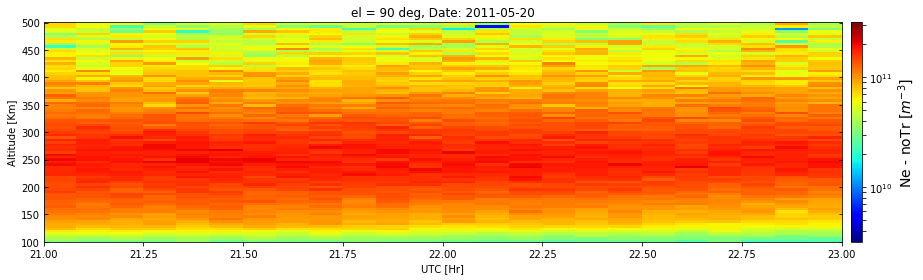

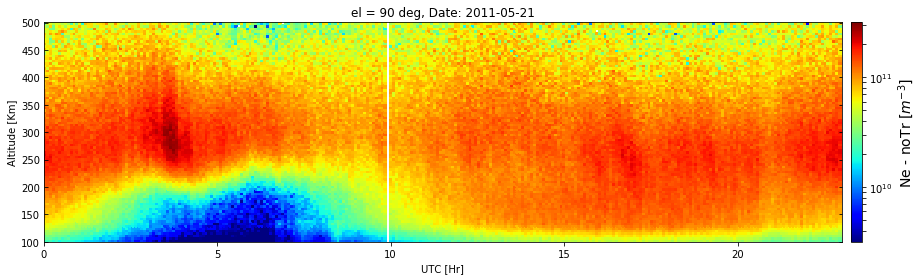

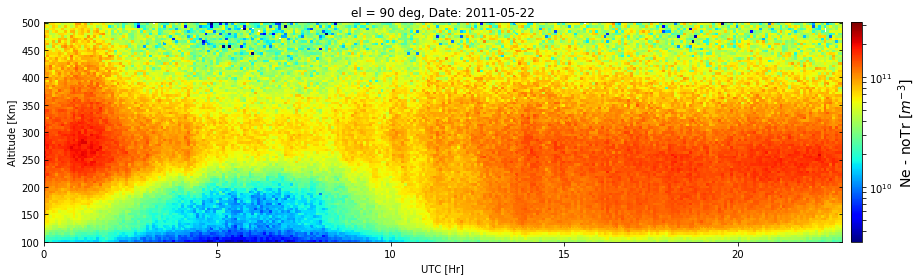

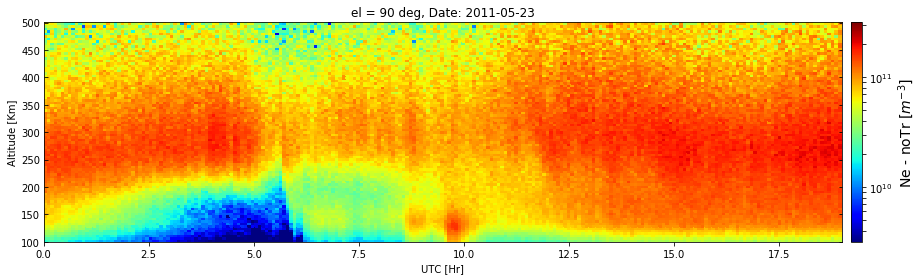

In [10]:
files = glob.glob('/Users/tedipro/Desktop/Atmos Research/ISR Data/*')

for i in range(len(files)):
    file_name = h5py.File(files[i],'r')
    e_density_data(file_name)
    filtered_data(file_name)
    file_name.close()